In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from collections import Iterable
import six

CRF = 0.50
g_sfc = 9.8 m s^-2


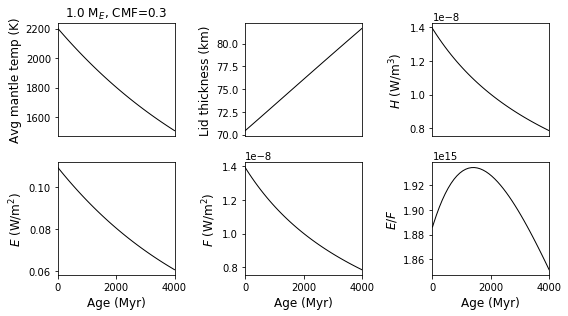

In [27]:
""" try to reproduce McKenzie+ 1981 """

M_E = 5.972e24 # earth mass in kg
R_E = 6371e3 # earth radius in m
L_sun =  3.9e26 # solar luminosity in W
years2sec = 31557600
AU2m = 1.5e11
sb = 5.67e-8 # Stefan Boltzmann constant in W m^-2 K^-4
R_b = 8.3144598 # universal gas constant in J mol −1 K −1

# Half-lives in years from Dye (2012) in Treatise on Geophys
t_40K_half = 1.26e9 
t_235U_half = 7.04e8 
t_238U_half = 4.46e9
t_232Th_half = 1.4e10

# Heating rates of radioisotopes per mass of isotope at tau=0 in W kg^-1 from Dye (2012) in Treatise on Geophys
h_40K_0 = 28.47e-6
h_235U_0 = 568.47e-6
h_238U_0 = 95.13e-6
h_232Th_0 = 26.3e-6

# radioisotope abundances
X_K = 250 # initial abundance of K in wt ppm (in Treatise on Geophysics, think these are by weight but double check)
X_U = 2e-2# initial abundane of U in wt ppm ""
X_Th = 7e-2 # initial abundance of Th in wt ppm ""
# TODO: are the below values in moles or mass? 
K_0 = 0.0117e-2 # ratio of 40-K to total K at time 0 (in Treatise on Geophysics)
U_0_235 = 0.0072 # ratio of 235-U to total U at time 0 (in Treatise on Geophysics)
U_0_238 = 0.9927 # ratio of 238-U to total U at time 0 (in Treatise on Geophysics)
Th_0 = 1 # ratio of 232-Th to total Th at time 0 (in Treatise on Geophysics)
H_0 = [h_40K_0, h_235U_0, h_238U_0, h_232Th_0]
X_0 = [X_K, X_U, X_U, X_Th]
el_0 = [K_0, U_0_235, U_0_238, Th_0]
t_half = [t_40K_half, t_235U_half, t_238U_half, t_232Th_half]

L=1 # stellar luminosity in solar units
Alb=0
rho_c = 8000 # Density of iron core in kg m^-3 
rho_m = 3000 #4500 # Density of silicate mantle in kg m^-3
#what is the right mantle density? low P highP?
#when doing these simple scalings, knowing the rock properties vary as a f(pt) 
#what p,t do we take the property at?

Q_cmb_Earth = 11e12 # heat flux from (Earth's) core in W

# thermo/geodynamic parameters
eta_m = 10**20 # Pa s, constant, actually eta... i.e. not kinematic viscosity but the other one
Ra_c = 660 # critical Rayleigh number (in Driscoll & Bercovici 2014)
c_pm = 1200 # in Dorn, Noack & Rozal 2018
#c_pm = 800 # specific heat capacity of silicate material (at constant volume) in J kg−1 K−1 (Elkins-Tanton+ 2011)
# can you use the same c_pm for lid and mantle?
# check if this is the right value for constant volume heat capacity
alpha_m = 2e-5 # thermal expansivity of silicate mantle in K^-1
k_m = 4 # thermal conductivity of silicate mantle in W m^−1 K^−1




def SA(M=None, rho=None, R=None, V=None):
    if R is None:
        if (V is None) and (M is not None) and (rho is not None):
            V = vol(M, rho)
        else:
            print('Missing mass or density to calculate volume')
        R = radius(V)
    return 4*np.pi*R**2

def radius_by_v(V):
    return (3*V/(4*np.pi))**(1/3)

def radius_basic(M_p, CRF, rho_m, rho_c):
    """Calculate radius of planet given total mass, assume lid (bndy layer) has the same density as mantle
    
    Parameters
    ----------
    M_p : float
        Mass of planet
    rho_m : float
        Mantle density
    F_c : float
        Core fraction in terms of radius
    rho_c : float
        Core density
    """
    
    R_p = ( 3*M_p/(4*np.pi) / (rho_m - CRF**3*rho_m + CRF**3*rho_c) )**(1/3)
    return R_p

def radius_seager(M_p, CMF=0.3, k1=-0.20945, k2=0.0804, k3=0.394, m1=None, r1=None):
    if (m1 is None) and (r1 is None):
        if CMF==0.3:
            m1 = 6.41*M_E
            r1 = 2.84*R_E
        elif CMF==0.675:
            m1 = 6.41*M_E
            r1 = 3.19*R_E
        elif CMF==0: # all perovskite
            m1 = 7.38*M_E
            r1 = 3.58*R_E
    M_s = M_p/m1
    R_s = 10**(k1 + 1/3*np.log10(M_s) - k2*M_s**k3)
    return R_s*r1

def radius_otegi(M_p):
    return np.exp(1/3.45*np.log(M_p/0.9))

def radius_zeng(M_p, CMF=None):
    # applicable to M_E <= 8 and CMF <= 0.4
    print('using Zeng radius model')
    return (1.07 - 0.21*CMF)*(M_p/M_E)**(1/3.7)

def vol(M, rho):
    try:
        return M/rho
    except TypeError:
        return np.array(M)/np.array(rho)

def luminosity(tau, L=None, **kwargs):
    return L
    
def q_star(t=None, Alb=None, a=None, **kwargs):
    """Calculate incident stellar flux density (over entire heliocentric sphere with radius a) in W m^-2"""
    return luminosity(t, **kwargs)*(1-Alb)/(4*np.pi*a**2) # 4pi is the total solid angle subtended by a sphere

def thermal_diffusivity(k, rho, C_p):
    """
    Calculate thermal diffusivity
    
    Parameters
    ----------
    k : Thermal conductivity
    C_p : Specific heat capacity in J K^-1 kg^-1
    rho : density in kg m^-3
    """
    #print('kappa', k/(rho*C_p), 'm^2 s^-1')
    return k/(rho*C_p)

def grav(M, R):
    """Calculate acceleration due to gravity on a point mass in m s^-2"""
    return 6.674e-11*M/R**2

def init(k_m=None, rho_m=None, rho_c=None, c_pm=None, CMF=None, M_p=None, **kwargs):
    R_p = 6370e3 #radius_zeng(M_p, CMF)*R_E # in m
    CRF = 0.5 #CMF**0.5 # Zeng & Jacobsen 2017
    print('CRF =', '%.2f'%CRF)
    R_c = R_p*CRF
    SA_p = SA(R=R_p)
    SA_c = SA(R=R_c) # core surface area 
    g_sfc = 9.8 #grav(M_p, R_p)
    print('g_sfc =', g_sfc, 'm s^-2')
    M_m = M_p*(1 - CMF) # mass of mantle
    kappa_m = 1e-6 #thermal_diffusivity(k_m, rho_m, c_pm)
    return dict(kappa_m=kappa_m, SA_p=SA_p, SA_c=SA_c, M_m=M_m, g=g_sfc, R_p=R_p, R_c=R_c, CRF=CRF)

def Ra(eta=None, kappa=None, alpha=None, rho=None, g=None, deltat=None, l=None):
    return rho*alpha*deltaT*l**3*g/(kappa*eta)

def lid_thickness(T_s=None, T_m=None, Ra_c=None, eta_m=None, alpha_m=None, rho_m=None, g=None, 
                  nu_m=None, kappa_m=None, **kwargs):
    """Thickness of uppper mantle thermal boundary layer 
    
    Parameters
    ----------
    T_s : float
        Surface temperature
    Ra_c : float
        Critical Rayleigh number
    alpha_m : float 
        Thermal expansivity in
    kappa : float 
        Thermal diffusivity in
    eta_m : float
        Mantle viscosity in Pa s
    g : float
        Acceleration due to gravity in m s^-2
    
        
    Returns
    -------
    d : float
        Lid thickness in m
    """
    
    # Set Rayleigh number at critical value
    if nu_m is None:
        d = (Ra_c*eta_m*kappa_m/(alpha_m*rho_m*g*(T_m - T_s)))**(1/3)
    elif (nu_m is not None) and (eta_m is None):
        d = (Ra_c*nu_m*kappa_m/(alpha_m*g*(T_m - T_s)))**(1/3)
    return d

def visc(T=None, eta_0=None, visc_type=None, **kwargs):
    if visc_type=='const':
        try:
            return [eta_0]*len(T)
        except TypeError:
            return eta_0
    elif visc_type=='Dorn':
        return nu_Dorn(T, **kwargs)
    elif visc_type=='KW':
        return nu_KW(T, **kwargs)

def T_sfc(q_out=None, **kwargs):
    """Calculate equilibrium surface temperature given outgoing radiation in W m^-2"""
    return (q_out/sb)**(1/4)

def q_sfc_outgoing(R_p=None, SA_p=None, **kwargs):
    return q_star(**kwargs)*(np.pi*R_p**2)/SA_p # assume no geothermal contribution, pi*R^2 cancels out

def h_rad(t=None, tf=None, H_0=None, X_0=None, el_0=None, t_half=None, t_vect=False, **kwargs):
    """Calculate radiogenic heating in W kg^-1"""
    if not t_vect:
        return sum(H_0*X_0*el_0*np.exp(-np.log(2)*t/t_half))
    else:
        # for a list of ages
        h = np.zeros(len(t))
        for ii, val in enumerate(t):
            h[ii] = sum(H_0*X_0*el_0*np.exp(-np.log(2)*val/t_half))
        return h
        
def Q_rad(t=None, M_m=None, c_v=None, **kwargs):
    """Calculate energy flux radioisotope decay in W"""
    h = h_rad(t, **kwargs)
    #print('h =', h, 'W kg^-1 @ t =',t*1e-6/years2sec, 'Myr')
    return h*M_m # mass cancels out

def F_bttm(t=None, t_R=None, F0=None, SA_p=None, t_vect=False, **kwargs):
    # flux into bottom layer in W m^-2 (or over unit area)
    return F0*(1-np.exp(-t/t_R))
    # need a layer generating heat below this layer of unit volume
    #return h_rad(t=t, t_vect=t_vect, **kwargs)*rho_m/SA_p

def Q_cmb(q_cmb=None, SA_c=None, M_m=None, c_v=None, **kwargs):
    """Calculate energy flux from core in W"""
    SA_c_Earth = SA(R=3480e3)
    q_cmb = Q_cmb_Earth/(4*np.pi*SA_c_Earth**2) # Heat flux across CMB in W m^-2, use earth value for now
    return q_cmb*SA_c
    
def Q_cond(T_m=None, T_s=None, k_m=None, M_m=None, c_v=None, SA_p=None, **kwargs):
    """Calculate energy flux from conduction across thermal bdy layer in W"""
    eta_um = visc(T_m, **kwargs) # upper mantle viscosity (non-kinematic)
    d_lid = lid_thickness(T_m=T_m, T_s=T_s, nu_m=2e17, **kwargs) #eta_m=eta_um, 
    return SA_p*k_m*(T_m - T_s)/d_lid 
    
def EF_ratio(t=None, T_m=None, T_s=None, T_m0=None, t_vect=False, R_p=None, rho_m=None, **kwargs):
    E = Q_cond(T_m=T_m, T_s=T_s, **kwargs) # flux out of top (i.e. conduction across lid) in W per unit area
    E0 = Q_cond(T_m=T_m0, T_s=T_s, **kwargs) # initial conductive flux
    H = h_rad(t, t_vect=t_vect, **kwargs)*rho_m
    #F = F_bttm(t=t, F0=E0, t_vect=t_vect, **kwargs) # flux into bottom (i.e. radiogenic) in W per unit area
    F = R_p*H/3
    return E/F
    
def dTdt(t, T_m, Q_core=None, M_m=None, c_v=None, R_p=None, rho_m=None, **kwargs):
    """R.H.S. of ODE for mantle temperature change"""
    #print('t, T_m', t, T_m)
    H = h_rad(t, t_vect=False, **kwargs)*rho_m
    Q_core=R_p*H/3
    return (-Q_cond(T_m=T_m, **kwargs) + Q_rad(t, **dict(M_m=M_m), **kwargs) + Q_core)/(M_m*c_v)
    #return (-Q_cond(T_m=T_m, **kwargs) + F_bttm(t, **kwargs) + Q_core)/(M_m*c_v)

def solve_Tm(tf=None, T_m0=None, t0=0, plots=False, plots_save=False, fend='', M_p=None, **kwargs):
    derargs = init(M_p=M_p, **kwargs)
    q_out = q_sfc_outgoing(**derargs, **kwargs)
    T_s = 273#T_sfc(q_out)
    Q_core = Q_cmb(**derargs, **kwargs)
    M_ME = M_p/M_E
    M_mME = derargs['M_m']/M_E
    f = integrate.solve_ivp(fun=lambda t, y: dTdt(t, y, **dict(T_s=T_s, Q_core=Q_core, M_p=M_p, 
                                                  **derargs, **kwargs)), 
                            t_span=(t0,tf), y0=[T_m0], max_step=100e6*years2sec,
                            method='RK45', t_eval=None, dense_output=False, events=None)
    #print(f)
    if plots:
        #tprime = f.t*derargs['kappa']/derargs['kappa']**2
        rad_heating = h_rad(f.t, t_vect=True, **kwargs)*rho_m #F_bttm(f.t, t_vect=True, **derargs, **kwargs)
        cond_cooling = Q_cond(f.y[0], T_s, **derargs, **kwargs)/derargs['SA_p']
        urey = rad_heating/cond_cooling
        #d_lid = lid_thickness(T_m=f.y[0], T_s=T_s, eta_m=visc(f.y[0]), **derargs, **kwargs)
        d_lid = lid_thickness(T_m=f.y[0], T_s=T_s, nu_m=2e17, **derargs, **kwargs)
        
        fig, axes = plt.subplots(2, 3, figsize=(8,4.5))
        plot_one(axes[0][0], f.t*1e-6/years2sec, 
                 f.y[0],
                 '', 'Avg mantle temp (K)', xticks=False)
        #plot_structure(axes[0][1], R_p, R_cmb)
        plot_one(axes[0][1], f.t*1e-6/years2sec, 
                 d_lid*1e-3, 
                 '', 'Lid thickness (km)', xticks=False)
        plot_one(axes[0][2], f.t*1e-6/years2sec, h_rad(f.t, t_vect=True, **kwargs)*kwargs['rho_m'], 
                 '', '$H$ (W/m$^3$)', xticks=False)
        
        plot_one(axes[1][0], f.t*1e-6/years2sec, 
                 cond_cooling, 
                 'Age (Myr)', '$E$ (W/m$^2$)', xticks=True)
        plot_one(axes[1][1], f.t*1e-6/years2sec, 
                 rad_heating,
                 'Age (Myr)', '$F$ (W/m$^2$)', xticks=True)
        plot_one(axes[1][2], f.t*1e-6/years2sec, 
                 EF_ratio(t=f.t, T_m=f.y[0], T_s=T_s, T_m0=T_m0, t_vect=True, **derargs, **kwargs), 
                 'Age (Myr)', '$E/F$', xticks=True)

        axes[0][0].set_title(str(M_p/M_E)+' M$_E$, CMF='+str(CMF))
        plt.tight_layout()
        if plots_save:
            fig.savefig('figs/evol_M'+str(M_p/M_E)+'_CMF'+str(CMF)+fend+'.pdf', bbox_inches='tight')
    return f.t, f.y

def plot_structure(ax=None, R_p=None, R_cmb=None, labelsize=12, legsize=14, **kwargs):
    x=[0, 1]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_ylabel('$z$ (km)', fontsize=labelsize)
    ax.set_xticks([])
    ax.set_ylim([0, R_p*1e-3])
    ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(0, 0, 'Core', ha='left', va='bottom', transform=ax.transAxes, fontsize=legsize)
    ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(0, R_cmb*1e-3, 'Mantle', ha='left', va='bottom', transform=ax.transAxes, fontsize=legsize)
    #ax.axhline(y=R_p*1e-3)
    return ax

def plot_one(ax, x, y, xlabel, ylabel, labelsize=12, legsize=14, lw=1, ls='-', marker=None, 
             ms=5,c='k', text=None, xticks=True, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

# run parameters in Earth units
M_p = 1 # planet mass in M_E
a = 1 # semi-major axis in au
CMF = 0.3 # core mass fraction
t_f = 4 # age in Gyr
T_m0 = 2200 # initial mantle temperature in K
paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_c=Ra_c, c_pm=c_pm,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, rho_c=rho_c, eta_0=eta_m, visc_type='const',
                 c_v=c_pm, ) #<----???
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=False, fend='', **varargs, **paramargs)

    
# TODO output a nice plot showing relative core/mantle radii and printing bulk properties... or do T profile
